In [0]:
import numpy as np
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls /content/drive/My\ Drive
#!ls -F /content/drive/My\ Drive/DPP/outtest2 |grep -v / | wc -l

In [0]:
with open("/content/drive/My Drive/binary/C1--Trace--00306.trc", "rb") as file:
     data = file.read(8)
with open("out.txt", "w") as f:
   f.write(" ".join(map(str,data)))
   f.write("\n")

In [0]:
x = np.genfromtxt('out.txt', delimiter=',')

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
data = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00306.trc.txt', delimiter=',')
data2 = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00307.trc.txt', delimiter=',')

In [0]:
data.shape

(1000002, 2)

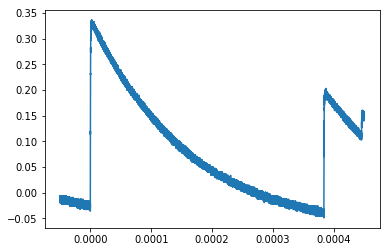

In [0]:
plt.plot(data1[:,0], data1[:, 1]*-1)

In [0]:
def moving_avg(a, x, prev):
  return (x+a*prev)/(1+a)
data1[:, 1] = data1[:, 1]*-1
h=[];
diff = []
a = 0.9
prev_y = data[0][1]
for i in data[1:, 1]:
  diff.append(abs(i-prev_y))
  if (abs(i-prev_y)>0.025):
    h.append(abs(i-prev_y))
  prev_y = i


In [0]:
def getdiff(file):
  data = np.genfromtxt(file, delimiter=',')
  data[:, 1] = data[:, 1]*-1
  t = abs(data[1:, 1]-data[:-1, 1])
  return np.array(t)
  

In [0]:
x = getdiff('/content/drive/My Drive/DPP/outtest2/C1--Trace--00306.trc.txt')
for i in range(307, 401):
  t = getdiff('/content/drive/My Drive/DPP/outtest2/C1--Trace--00{}.trc.txt'.format(i))
  x = np.concatenate((x, t), axis=0)

In [0]:
data = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00306.trc.txt', delimiter=',')
data[:, 1] = data[:, 1]*-1
prev = data[0, 1]
a = 0.5; a1=0.99
l = [data[0, 1]]
for i in range(len(data[1:, 1])):
  x = data[i, 1]
  l.append((prev+a*x)/(1+a))
  prev = prev*a1+(1-a1)*x

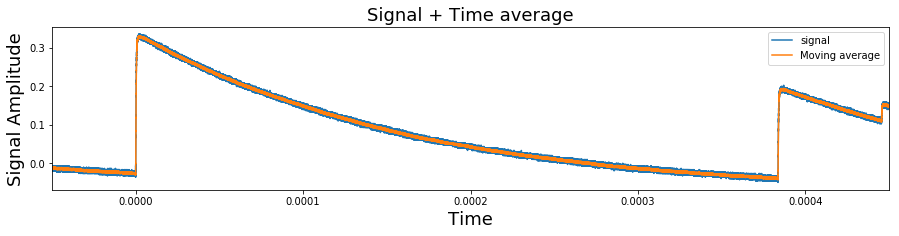

In [0]:
#plt.plot(data[:, 0], l)
#plt.plot(data[:, 0], data[:, 1])
#plt.show()
fig, ax= plt.subplots(figsize=(15, 3))
#time_ave, signal_ave = get_ave_values(time, signal, average_over)
ax.plot(data[:, 0], data[:, 1], label='signal')
ax.plot(data[:, 0], l, label='Moving average')
ax.set_xlim(data[0, 0], data[-1, 0])
ax.set_ylabel('Signal Amplitude', fontsize=18)
ax.set_title('Signal + Time average', fontsize=18)
ax.set_xlabel('Time', fontsize=18)
ax.legend()
plt.show()

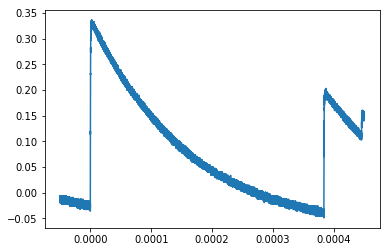

In [0]:
#x = np.concatenate((t1, t2), axis=0)
plt.plot(data[:, 0], data[:, 1])

In [0]:
#np.median(t)
t3 = t1
t3 = np.delete(t3, np.where(t3<0.014))
t3 = np.delete(t3, np.where(t3>0.019))

In [0]:
max(data[:, 1]), data[0, 1]

(0.382293, -0.0162189)

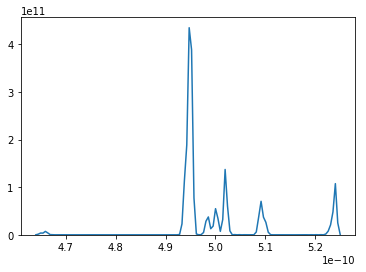

In [0]:
sns.distplot(t, hist=False)

In [0]:
## getting familiar with wavelet transform using El-nino dataset
import os
import pywt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import seaborn as sns
import h5py

In [0]:
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


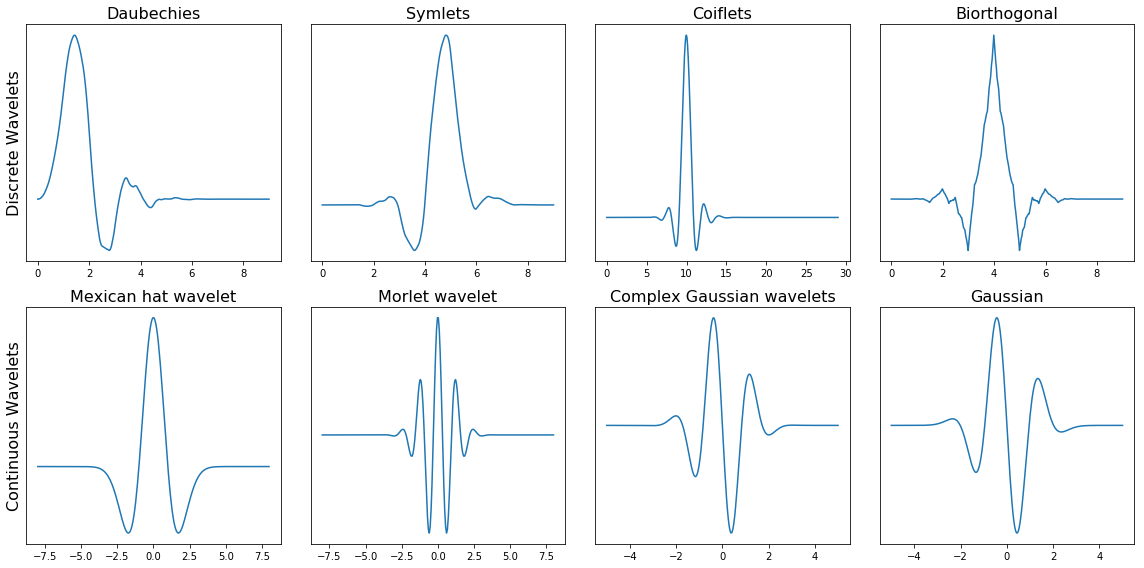

In [0]:
## Visualizing different wavelets
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']

list_list_wavelets = [discrete_wavelets, continous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]

fig, axarr = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 8))
for ii, list_wavelets in enumerate(list_list_wavelets):
  funcs = list_funcs[ii]
  row_no = ii
  for col_no, wavelet_name in enumerate(list_wavelets):
    wavelet = funcs(wavelet_name)
    family_name = wavelet.family_name
    biorthogonal = wavelet.biorthogonal
    orthogonal = wavelet.orthogonal
    symmetry = wavelet.symmetry
    if ii==0:
      _ = wavelet.wavefun()
      wavelet_function = _[0]
      x_values = _[-1]
    else :
      wavelet_function, x_values = wavelet.wavefun()
    if col_no==0 and ii==0:
      axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
    if col_no==0 and ii==1:
      axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
    axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
    axarr[row_no, col_no].plot(x_values, wavelet_function)
    axarr[row_no, col_no].set_yticks([])
    axarr[row_no, col_no].set_yticklabels([])
    
plt.tight_layout()
plt.show()

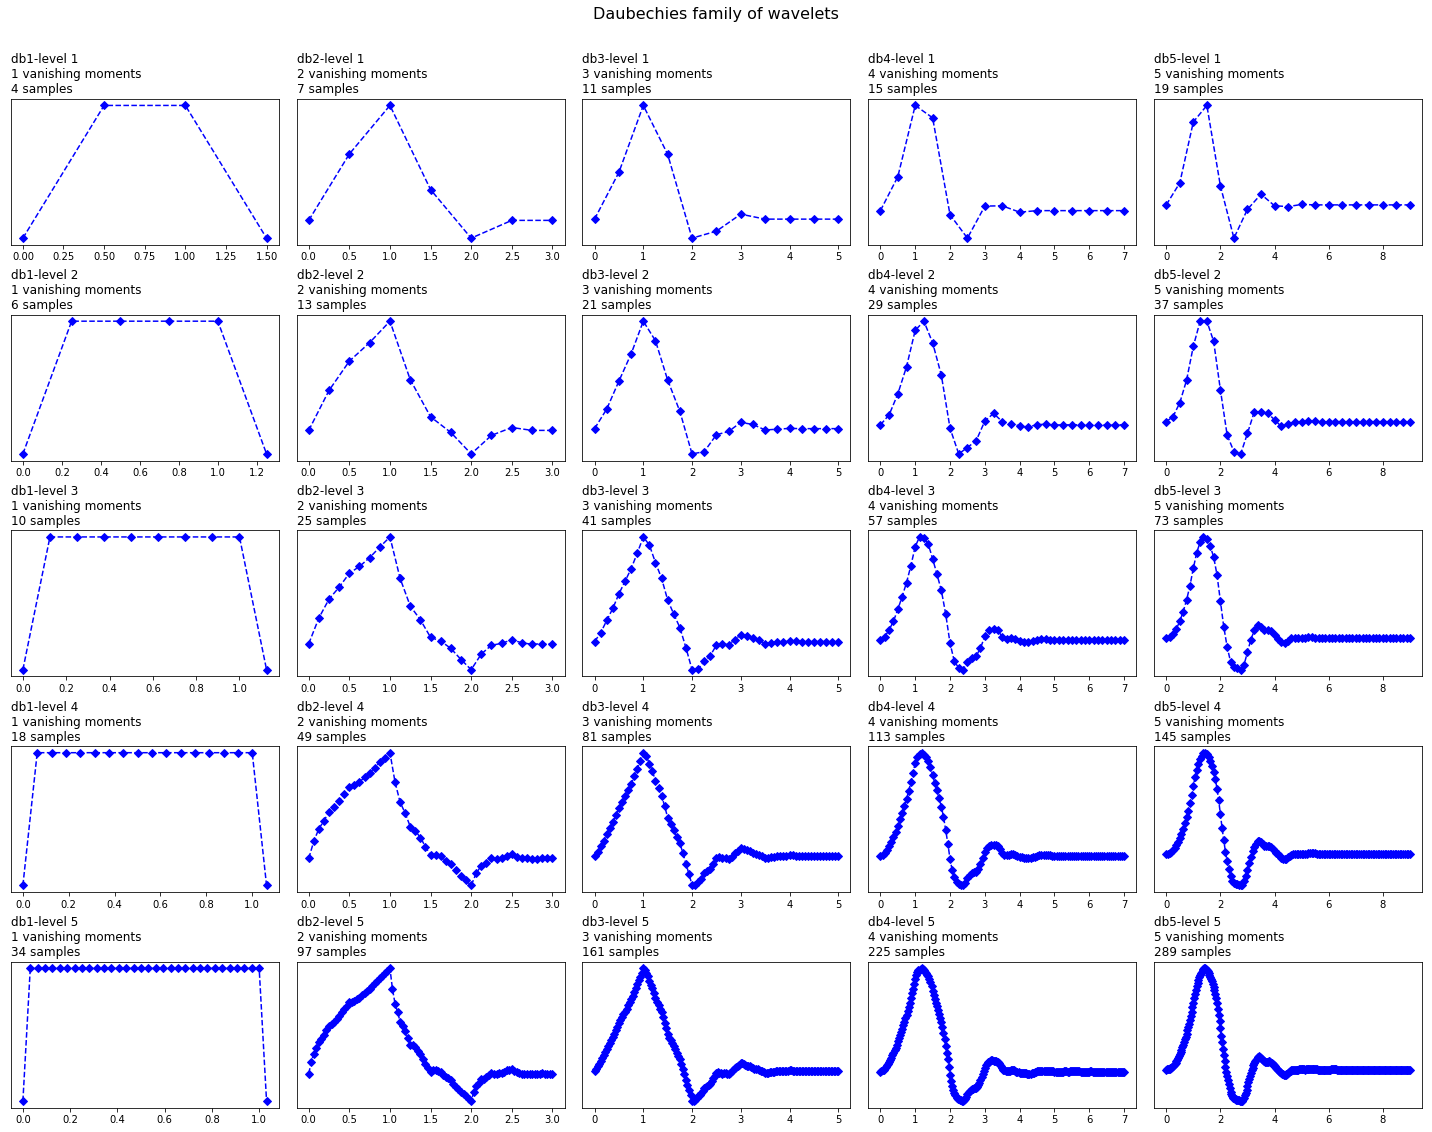

In [0]:
db_wavelets = pywt.wavelist('db')[:5]

fig, axarr = plt.subplots(nrows=5, ncols =5, figsize=(20, 16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)
for col_no, wavelet_name in enumerate(db_wavelets):
  wavelet = pywt.Wavelet(wavelet_name)
  no_moments = wavelet.vanishing_moments_psi
  family_name = wavelet.family_name
  for row_no, level in enumerate(range(1,6)):
    wavelet_function, scaling_function, x_values = wavelet.wavefun(level=level)
    axarr[row_no, col_no].set_title("{}-level {}\n{} vanishing moments\n{} samples".format(wavelet_name, level, no_moments, len(x_values)), loc='left')
    axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
    axarr[row_no, col_no].set_yticks([])
    axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

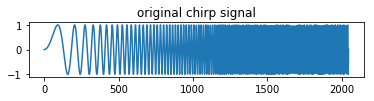

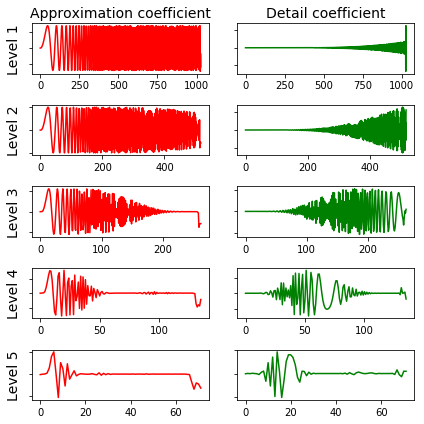

In [0]:
## expermenting with a chirp signal
x = np.linspace(0, 1, num =2048)
chirp_signal = np.sin(250*np.pi*x**2)

fig, ax  = plt.subplots(figsize=(6,1))
ax.set_title("original chirp signal")
ax.plot(chirp_signal)
plt.show()

data = chirp_signal
waveletname = 'sym5'

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6, 6))
for ii in range(5):
  (data, coeff_d) = pywt.dwt(data, waveletname)
  axarr[ii, 0].plot(data, 'r')
  axarr[ii, 1].plot(coeff_d, 'g')
  axarr[ii, 0].set_ylabel("Level {}".format(ii+1), fontsize=14, rotation=90)
  axarr[ii, 0].set_yticklabels([])
  if ii==0:
    axarr[ii, 0].set_title("Approximation coefficient", fontsize=14)
    axarr[ii, 1].set_title("Detail coefficient", fontsize=14)
  axarr[ii, 1].set_yticklabels([])
  
plt.tight_layout()
plt.show()

In [0]:
elnino = np.genfromtxt('/content/drive/My Drive/elnino.csv', delimiter=',')

In [0]:
# load the el-nino dataset
dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_csv(dataset, sep='\t')
N = df_nino.shape[0]
t0 = 1871
dt = 0.25
time = np.arange(0, N)*dt + t0
signal = df_nino.values.squeeze()

In [0]:
data = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00306.trc.txt', delimiter=',')
signal = data[:, 1]*-1
time = data[:, 0]

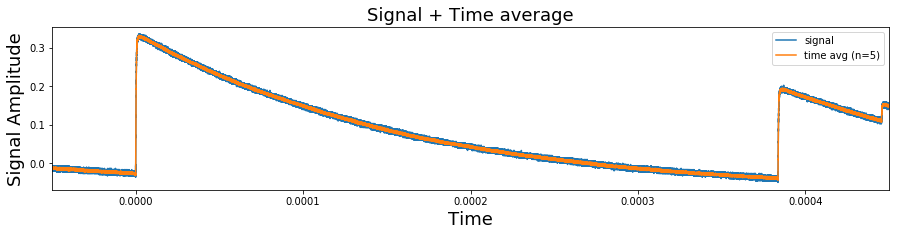

In [0]:
# plotting data along with average

def get_ave_values(x_values, y_values, n=5):
  signal_len = len(x_values)
  if signal_len%n==0:
    padding_len = 0
  else :
    padding_len = n-signal//n%n
  xarr = np.array(x_values)
  yarr = np.array(y_values)
  xarr.resize(signal_len//n, n)
  yarr.resize(signal_len//n, n)
  xarr_reshaped = xarr.reshape((-1, n))
  yarr_reshaped = yarr.reshape((-1, n))
  x_ave = xarr_reshaped[:, 0]
  y_ave = np.nanmean(yarr_reshaped, axis=1)
  return x_ave, y_ave

def plot_signal_plus_average(time, signal, average_over=5):
  fig, ax= plt.subplots(figsize=(15, 3))
  time_ave, signal_ave = get_ave_values(time, signal, average_over)
  ax.plot(time, signal, label='signal')
  ax.plot(time_ave, signal_ave, label='time avg (n={})'.format(average_over))
  ax.set_xlim(time[0], time[-1])
  ax.set_ylabel('Signal Amplitude', fontsize=18)
  ax.set_title('Signal + Time average', fontsize=18)
  ax.set_xlabel('Time', fontsize=18)
  ax.legend()
  plt.show()
  
plot_signal_plus_average(time, signal)

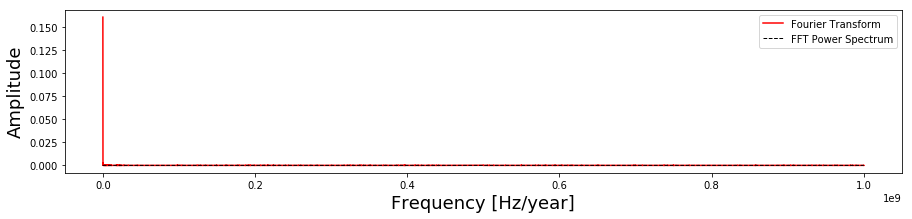

In [0]:
# plotting fourier transform of the data
def get_fft_values(y_values, T, N, f_s):
  f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
  fft_values_ = fft(y_values)
  fft_values = 2.0/N*np.abs(fft_values_[0:N//2])
  return f_values, fft_values

def plot_fft_plus_power(time, signal):
  dt = time[1]-time[0]
  N=len(signal)
  fs = 1/dt
  
  fig, ax= plt.subplots(figsize=(15, 3))
  variance = np.std(signal)**2
  f_values, fft_values = get_fft_values(signal, dt, N, fs)
  fft_power = variance*abs(fft_values)**2
  ax.plot(f_values, fft_values, 'r-', label = 'Fourier Transform')
  ax.plot(f_values, fft_power, 'k--', linewidth=1, label = 'FFT Power Spectrum')
  ax.set_xlabel('Frequency [Hz/year]', fontsize=18)
  ax.set_ylabel('Amplitude', fontsize=18)
  ax.legend()
  plt.show()

plot_fft_plus_power(time, signal)

/usr/local/lib/python3.6/dist-packages/pywt/_cwt.py:74: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':


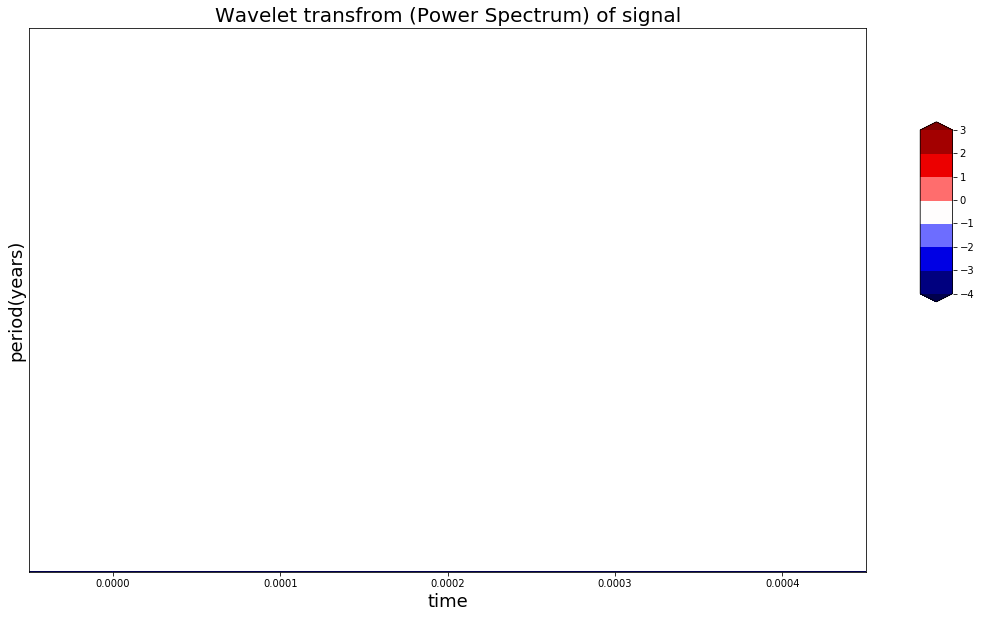

In [0]:
# plot scaleogram using Continuous wavelet Transform
def plot_wavelet(time, signal, scales, waveletname='cmor',
                 cmap=plt.cm.seismic, title='Wavelet transfrom (Power Spectrum) of signal',
                 ylabel = 'period(years)', xlabel='time'):
  dt = time[1]-time[0]
  [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
  power = (abs(coefficients))**2
  period = 1./frequencies
  levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
  contourlevels = np.log2(levels)
  
  fig, ax = plt.subplots(figsize=(15, 10))
  im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both', cmap=cmap)
  
  ax.set_title(title, fontsize=20)
  ax.set_ylabel(ylabel, fontsize=18)
  ax.set_xlabel(xlabel, fontsize=18)
  
  yticks = 2**(np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max()))))
  ax.set_yticks(np.log2(yticks))
  ax.set_yticklabels(yticks)
  ax.invert_yaxis()
  ylim = ax.get_ylim()
  ax.set_ylim(ylim[0], -1)
               
  cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
  fig.colorbar(im, cax = cbar_ax, orientation='vertical')
  plt.show()


scales = np.arange(1, 128)
plot_wavelet(time, signal, scales)

In [0]:
import scipy.io as sio
from IPython.display import display
import scipy.stats
import datetime as dt
from collections import defaultdict

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

In [0]:
dict_classifier = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Ada Boost": AdaBoostClassifier,
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "K-Nearest": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB(),
    "Gaussian Process": GaussianProcessClassifier(),
}

def batch_classify(X_train, Y_train, X_test, Y_test, no_classifier=5, verbose=True):
  dict_models={}
  for classifier_name, classifier in list(dict_classifier.items())[:no_classifier]:
    t_start = time.clock()
    classifier.fit(X_train, Y_train)
    t_end = time.clock()
    
    t_diff = t_end-t_start
    train_score = classifier.score(X_train, Y_train)
    test_score = classifier.score(X_test, Y_test)
    
    dict_model[classifier_name] = {'model':classifier,
                                   'train_score': train_score, 
                                   'test_score': test_score,
                                   'train time': t_diff}
    if verbose:
      print('Trained {c} in {f:.2f} s'.format(c=classifier_name, f=t_diff))
  return dict_model
  
def get_train_test(df, y_cols, x_cols, ratio):
  mask = np.random.rand(len(df))<ratio
  df_train = df[mask]
  df_test = df[~mask]
  
  Y_train = df_train[y_cols].values
  X_train = df_train[x_cols].values
  Y_test = df_test[y_cols].values
  X_test = df_test[x_cols].values
  
  return df_train, df_test, Y_train, X_train, Y_test, X_test

def display_dict_models(dict_model, sort_by='test_score'):
  clf = [key for key in dict_model.keys()]
  test_s = [dict_model[key]['test_score'] for key in clf]
  train_s = [dict_model[key]['train_score'] for key in clf]
  train_t = [dict_model[key]['train time'] for key in clf]
  
  df_ = pd.DataFrame(np.zeros(shape=(len(clf), 4)), columns=['classifier', 'test_score', 'train_score', 'train_time'])
  for ii in range(0, len(cls)):
    df_[ii, 'classifier'] = cls[ii]
    df_[ii, 'test_score'] = test_s[ii]
    df_[ii, 'train_score'] = train_s[ii]
    df_[ii, 'train_time'] = train_t[ii]
    
  display(df_.sort_values(by=sort_by, ascending=False))
  
def get_entropy(list_values):
  counter_values = Counter(list_values).most_common()
  prob = [elem[1]/len(list_values) for elem in counter_values]
  entropy = scipy.stats.entropy(prob)
  return entropy

def calculate_statistics(list_values):
  n5 = np.nanpercentile(list_values, 5)
  n25 = np.nanpercentile(list_values, 25)
  median = np.nanpercentile(list_values, 50)
  n75 = np.nanpercentile(list_values, 75)
  n95 = np.nanpercentile(list_values, 95)
  mean = np.nanmean(list_values)
  std = np.nanstd(list_values)
  var = np.nanvar(list_values)
  rms = np.nanmean(np.sqrt(list_values**2))
  return [n5, n25, n75, median, mean , std, var, rms]

def calculate_crossings(list_values):
  zero_crossing_indices = np.nonzero(np.diff(np.array(list_values)>0))[0]
  no_zero_crossings = len(zero_crossing_indices)
  mean_crossing_indices = np.nonzero(np.diff(bp.array(list_values)>np.nanmean(list_values)))[0]
  no_mean_crossings = len(mena_crossing_indices)
  return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
  entropy = get_entropy(list_values)
  no_crossings = calculate_crossings(list_values)
  statistics = calculate_statistics(list_values)
  return [entropy]+no_crossings+statistics

def get_uci_har_features(dataset, labels, waveletname):
  uci_har_features = []
  for signal_no in range(0, len(dataset)):
    features = []
    for signal_comp in range(0, dataset.shape[2]):
      signal = dataset[signal_no, :, signal_comp]
      list_coeff = pywt.wavedec(signal, waveletname)
      for coeff in list_coeff:
        features+=get_features(coeff)
    uci_har_features.append(features)
  X = np.array(uci_har_features)
  Y = np.array(labels)
  return X, Y

In [0]:
# loading the UCI_HAR Dataset
activities_description = {
    1:'walking',
    2:'walking upstairs',
    3:'walking downstairs',
    4:'sitting',
    5:'standing',
    6:'lying'
}
def read_signal(filename):
  with open(filename, 'r') as f:
    data = f.read().splitlines()
    data = map(lambda x: x.rstrip().lstrip().split(), data)
    data = [list(map(float, line)) for line in data]
  return data

def read_labels(filename):
  with open(filename, 'r') as f:
    activities = f.read().splitlines()
    activities = list(map(int, activities))
  return activities

def randomize(dataset, labels):
  perm = np.random.permutations(labels.shape[0])
  shuffled_dataset = dataset[perm, :, :]
  shuffled_labels = labels[perm]
  return shuffled_dataset, shuffled_labels

INPUT_FOLDER_TRAIN = './data/UCI_HAR/train/InertialSignals/'
INPUT_FOLDER_TEST = './data/UCI_HAR/test/InertialSignals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = './data/UCI_HAR/train/y_train.txt'
LABELFILE_TEST = './data/UCI_HAR/test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
  signal = read_signal(INPUT_FOLDER_TRAIN+input_file)
  train_signals.append(signal)
tarin_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
  signal = read_signal(INPUT_FOLDER_TEST+input_file)
  test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = train_signals.shape
[no_signals_test, no_steps_test, no_components_test] = test_signals.shape
no_labels = len(np.unique(train_labels[:]))

print('The train dataset contains {} signals, each one of length {} and {} components'.format(no_signals_train, no_steps_train, no_components_train))
print('The test dataset contains {} signals, each of length {} and {} components'.format(no_signals_test, no_steps_test, no_components_test))
print('The train dataset contains {} labels with the following distribution \n{}'.format(np.shape(train_labels)[0], Counter(train_labels[:])))
print('The test dataset contains {} labels with the following distribution \n{}'.format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_train_signals, uci_har_train_labels = randomize(train_signals, np.array(train_labels))
uci_har_test_signals, uci_har_test_labels = randomize(test_signals, np.array(test_labels))

FileNotFoundError: ignored

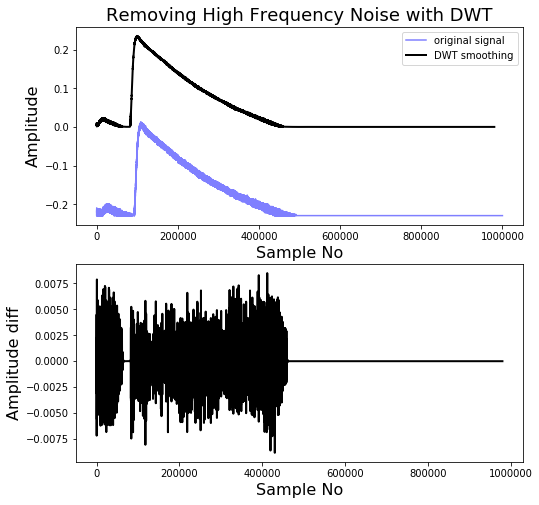

In [0]:
# removing high frequency noise
signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00464.trc.txt', delimiter=',')
signal = signal[:, 1]*-1

def lowpassfilter(signal, thres = 0.64, wavelet='db4'):
  thres = thres*np.nanmax(signal)
  coeff = pywt.wavedec(signal, wavelet, mode='per')
  coeff[1:] = (pywt.threshold(i, value=thres, mode='soft') for i in coeff[1:])
  reconstructed_signal = pywt.waverec(coeff, wavelet, mode='per')
  return reconstructed_signal

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(8, 8))
ax[0].plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.4, 'db4')[10000:-10000]
rec_mod = rec-min(rec)
diff = rec_mod[1:]-rec_mod[:-1]
ax[0].plot(rec_mod, 'k', label='DWT smoothing', linewidth=2)
ax[0].legend()
ax[1].plot(diff, 'k', label='Height difference', linewidth=2)
ax[0].set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[1].set_ylabel('Amplitude diff', fontsize=16)
ax[0].set_xlabel('Sample No', fontsize=16)
ax[1].set_xlabel('Sample No', fontsize=16)
plt.show()

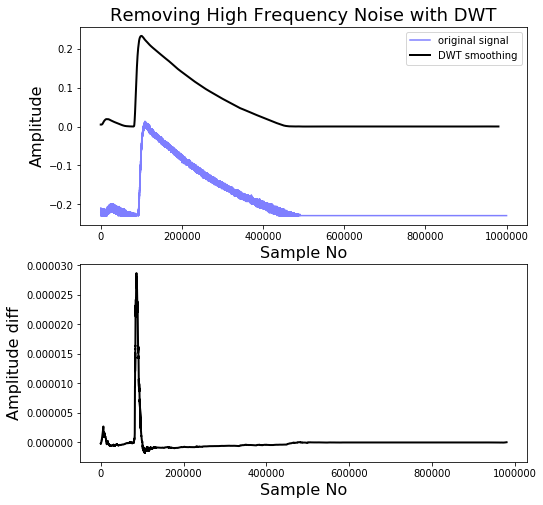

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(8, 8))
ax[0].plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.8)
rec_2  = lowpassfilter(rec, 0.8)
#rec_3 = lowpassfilter(rec_2, 0.4)
#rec_4 = lowpassfilter(rec_3, 0.4)
rec_crop = rec_2[10000:-10000]
rec_mod = rec_crop-min(rec_crop)
diff = rec_mod[1:]-rec_mod[:-1]
ax[0].plot(rec_mod, 'k', label='DWT smoothing', linewidth=2)
ax[0].legend()
ax[1].plot(diff, 'k', label='Height difference', linewidth=2)
ax[0].set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[1].set_ylabel('Amplitude diff', fontsize=16)
ax[0].set_xlabel('Sample No', fontsize=16)
ax[1].set_xlabel('Sample No', fontsize=16)
plt.show()

In [0]:
a = (np.max(diff)+abs(np.min(diff)))*0.5
peaks = np.where(diff>a)[0]
len(peaks)
prev = peaks[0]
peaks_mod = [peaks[0]]
for i in range(1, len(peaks)):
  if (peaks[i]-peaks[i-1]>200000):
    peaks_mod.append(peaks[i])
len(peaks_mod)

2

In [0]:
def find_peaks(diff):
  #thre = (np.max(diff)+np.abs(np.min(diff)))*0.5
  thre = np.max(diff)*0.5  
  peaks = np.where(diff>thre)[0]
  peaks_mod = [peaks[0]]  # cluster the time values to get distinct peaks
  for i in range(1, len(peaks)):
    if (peaks[i]-peaks[i-1]>200000):
      peaks_mod.append(peaks[i])
  return peaks_mod

def get_window(signal, peaks, window_sz=200000):
  cropped_signals=[]
  n = len(signal)
  for i in peaks:
      sig = signal[max(0, i-window_sz):min(n, i+window_sz)]
      cropped_signals.append(sig)
  return cropped_signals

In [0]:
def maxSubArraySum(a,size): 
    maxint = 10.0   
    max_so_far = -maxint - 1
    max_ending_here = 0
       
    for i in range(0, size): 
        max_ending_here = max_ending_here + a[i] 
        if (max_so_far < max_ending_here): 
            max_so_far = max_ending_here
  
        if max_ending_here < 0: 
            max_ending_here = 0   
    return max_so_far 

In [0]:
# Analysing time complexity of different functions
t = time.time()
i = 464
signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00{}.trc.txt'.format(i), delimiter=',')
signal = signal[:, 1]*-1
t_load = time.time()-t
t = time.time()
rec = lowpassfilter(signal, 0.4)[10000:-10000]
rec_mod = rec-min(rec)
diff = rec_mod[1:]-rec_mod[:-1]
t_diff = time.time()-t
t = time.time()
peaks = find_peaks(diff)
print(len(peaks))
t_peak = time.time()-t
t = time.time()
cropped_signals = get_window(diff, peaks)
t_window = time.time()-t
t = time.time()
for sig in cropped_signals:
  th = maxSubArraySum(sig, sig.shape[0])
t_height = time.time()-t
print("Time required for: \n 1.Loading data = ", t_load,
      "\n 2.Denoising data = ", t_diff,
      "\n 3.Finding peaks = ", t_peak,
      "\n 4.Cropping signals around peaks = ", t_window, 
      "\n 5.Getting heights = ", t_height)

"""
To decrease data loading time: Load once and save it for further processing.
      Need to experiment with denoising hence, can't save denoised data.
      
To decrease the time for finding height: tighten the bound around peaks to
      decrease window size as the time complexity of the the algorithm is O(n).
      
Also try decreasing the sampling rate, analyse performance-sampling rate
trade-off.
"""

1
Time required for: 
 1.Loading data =  3.334554433822632 
 2.Denoising data =  0.15912771224975586 
 3.Finding peaks =  0.0063860416412353516 
 4.Cropping signals around peaks =  0.00010514259338378906 
 5.Getting heights =  0.10799884796142578


In [0]:
# Saving data in h5py format
h5_data = []
t = time.time()
"""
for i in range(306, 1000):
  signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00{}.trc.txt'.format(i), delimiter=',')
  signal = signal[:, 1]*-1
  h5_data.append(signal)
  t2 = time.time()
  print("Signal ", i, " loaded in time ", t2-t, "s")
  t = t2

for i in range(1000, 2001):
  signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--0{}.trc.txt'.format(i), delimiter=',')
  signal = signal[:, 1]*-1
  h5_data.append(signal)
  t2 = time.time()
  print("Signal ", i, " loaded in time ", t2-t, "s")
  t = t2
"""
for i in range(3526, 3994):
  signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--0{}.trc.txt'.format(i), delimiter=',')
  signal = signal[:, 1]*-1
  h5_data.append(signal)
  t2 = time.time()
  print("Signal ", i, " loaded in time ", t2-t, "s")
  t = t2
h5 = h5py.File("/content/drive/My Drive/Dpp_data_3.5k_4k.h5py", "w")
h5.create_dataset("main", data=h5_data)
h5.close()

Signal  3526  loaded in time  3.4688775539398193 s


In [0]:
t = time.time()
dpp_data = h5py.File("/content/drive/My Drive/Dpp_data.h5py", "r")["main"]
t_h5 = time.time()-t
t = time.time()
dpp_sig = dpp_data[0]
t_1 = time.time()-t
print("Time to load the h5py file: ", t_h5,
      "\n Avg time per signal: ", t_h5*0.1,
      "\n Time to access a signal: ", t_1,)

Time to load the h5py file:  0.0020875930786132812 
 Avg time per signal:  0.00020875930786132813 
 Time to access a signal:  0.02496051788330078


In [0]:
# loading data to debug unusual spectrum shape(no compton scattering after the peak)
dpp_data = h5py.File("/content/drive/My Drive/Dpp_data.h5py", "r")["main"]

In [0]:
t = maxSubArraySum(diff, diff.shape[0])

In [0]:
len(h5_data)

NameError: ignored

In [0]:
#import time
#heights = []
errorneous_samples = []  # collecting samples to analyse for insufficient noise reduction
t1 = time.time()
for i in range(1000, 2001):
  signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--0{}.trc.txt'.format(i), delimiter=',')
  signal = signal[:, 1]*-1
  rec = lowpassfilter(signal, 0.4)[10000:-10000]  ## cropping signal to remove edge effect
  rec_mod = rec-min(rec)
  diff = rec_mod[1:]-rec_mod[:-1]
  peaks = find_peaks(diff)
  if (len(peaks)>3):
    errorneous_samples.append(i)
  '''
  cropped_signals = get_window(diff, peaks)
  for sig in cropped_signals:
    t = maxSubArraySum(sig, sig.shape[0])
    heights.append(t)
  '''
  if (i%10==0):
    print("Batch done, time taken: ", time.time()-t1)
    t1 = time.time()

Batch done, time taken:  4.017955541610718


/usr/local/lib/python3.6/dist-packages/pywt/_thresholding.py:25: RuntimeWarning: invalid value encountered in multiply
  thresholded = data * thresholded
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


Batch done, time taken:  39.736987352371216
Batch done, time taken:  39.99190640449524
Batch done, time taken:  39.678593158721924


KeyboardInterrupt: ignored

In [0]:
thre = (np.max(diff)+np.abs(np.min(diff)))*0.5
peaks = np.where(diff>thre)[0]
np.max(diff)

0.007444244097171093

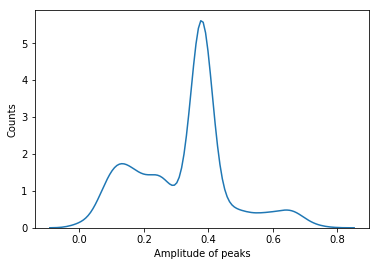

In [0]:
#import seaborn as sns
ax = sns.distplot(heights, hist=False)
ax.set_ylabel('Counts')
ax.set_xlabel('Amplitude of peaks')
plt.show()

In [0]:
t

0.3589674964623943

In [0]:
### Trying VAE on the dataset
#--- imports ---
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
import os

In [0]:
num_epoches = 100
batch_size = 10
learning rate = 1e-3

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(784, 400);
    self.fc21 = nn.Linear(400, 20);
    self.fc22 = nn.LInear(400, 20);
    self.fc3 = nn.Linear(20, 400);
    self.fc4 = nn.Linear(400, 784);

In [0]:
#--- Second semester ---

In [0]:
# Zip file for the training data
TransferXL-08v21CrTv7WCMF.zip

SyntaxError: ignored

In [0]:
# Unzip the dataset
!unzip /content/drive/My\ Drive/TransferXL-08v21CrTv7WCMF.zip

Archive:  /content/drive/My Drive/TransferXL-08v21CrTv7WCMF.zip
Downloaded using TransferXL
 extracting: traindata.csv           


In [0]:
!ls 

drive  sample_data  traindata.csv


In [0]:
from numpy import genfromtxt
import matplotlib.pyplot as plt

In [0]:
data = genfromtxt('traindata.csv', delimiter=",")

In [0]:
data.shape

(57930, 5)

In [0]:
total_values = data.shape[0]*data.shape[1]

In [0]:
nan_values = np.count_nonzero(np.isnan(data))

In [0]:
nan_values/total_values*100.

20.001380977041254

In [0]:
print(total_values)
print(nan_values)

289650
57934


In [0]:
reduced_data = data[~np.isnan(data[:, :4]).any(axis=1)] # last column of all the datapoints in Nan

In [0]:
reduced_data.shape

(57929, 5)

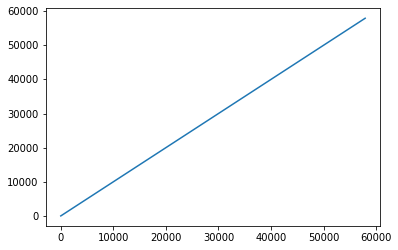

In [0]:
t = np.arange(reduced_data.shape[0])
plt.plot(t, reduced_data[:, 0])   # first column corresponds to the time steps, plot of t vs first volumn is linear.
plt.show()

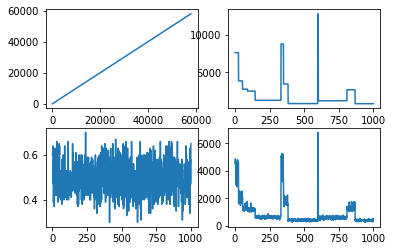

In [0]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(t, reduced_data[:, 0])
ax[0, 1].plot(reduced_data[:1000, 0], reduced_data[:1000, 1])
ax[1, 0].plot(reduced_data[:1000, 0], reduced_data[:1000, 3])
ax[1, 1].plot(reduced_data[:1000, 0], reduced_data[:1000, 2])
plt.show()

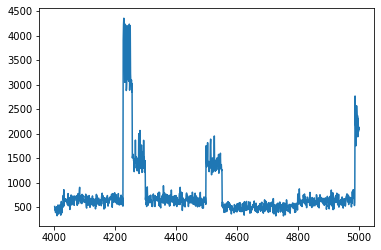

In [0]:
plt.plot(reduced_data[4000:5000, 0], reduced_data[4000:5000, 2])
plt.show()

In [0]:
# separate data points 
data_gamma = reduced_data[reduced_data[:, 3]>=0.5]
data_neut = reduced_data[reduced_data[:, 3]<0.5]

In [0]:
print(data_gamma.shape, data_neut.shape)

(25685, 5) (32244, 5)


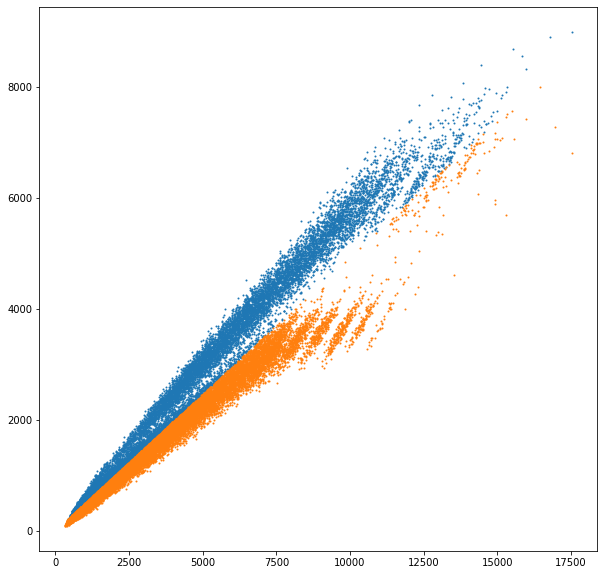

In [0]:
# There seems to be clear demarcation between the two when plotting tail area vs total area
plt.figure(figsize=(10, 10))
plt.scatter(data_gamma[:, 1], data_gamma[:, 2], s=1)
plt.scatter(data_neut[:, 1], data_neut[:, 2], s=1)
plt.show()

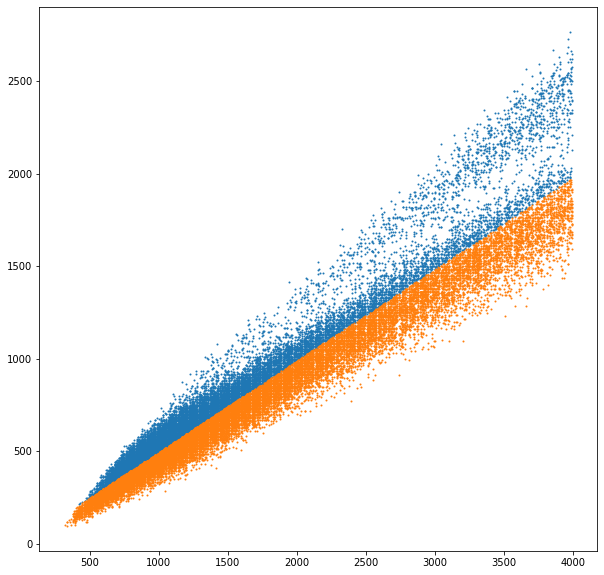

In [0]:
# focus on lower left region in the graph
lower_data_g = data_gamma[data_gamma[:, 1]<4000]
lower_data_n = data_neut[data_neut[:, 1]<4000]
plt.figure(figsize=(10, 10))
plt.scatter(lower_data_g[:, 1], lower_data_g[:, 2], s=1)
plt.scatter(lower_data_n[:, 1], lower_data_n[:, 2], s=1)
plt.show()

# the line of demarcation is the x=y line.

In [0]:
# try pca and then plotting
from sklearn.decomposition import PCA 

In [0]:
pca = PCA()
x = pca.fit_transform(reduced_data[:, 1:3])
x.shape

(57929, 2)

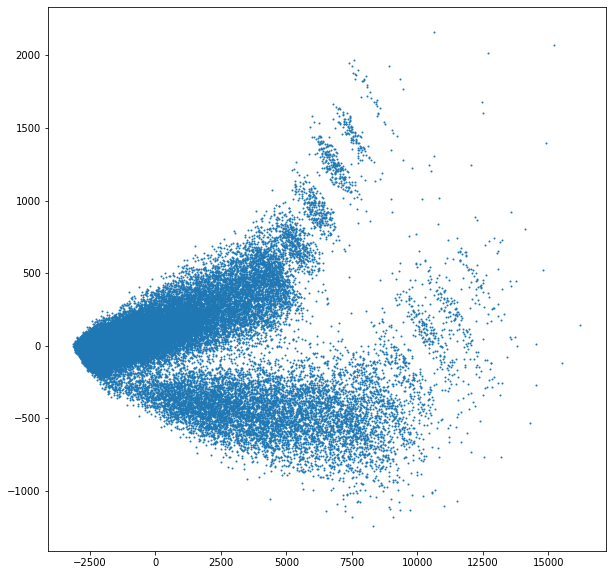

In [0]:
plt.figure(figsize=(10, 10))
plt.scatter(x[:, 0], x[:, 1], s=1)
plt.show()

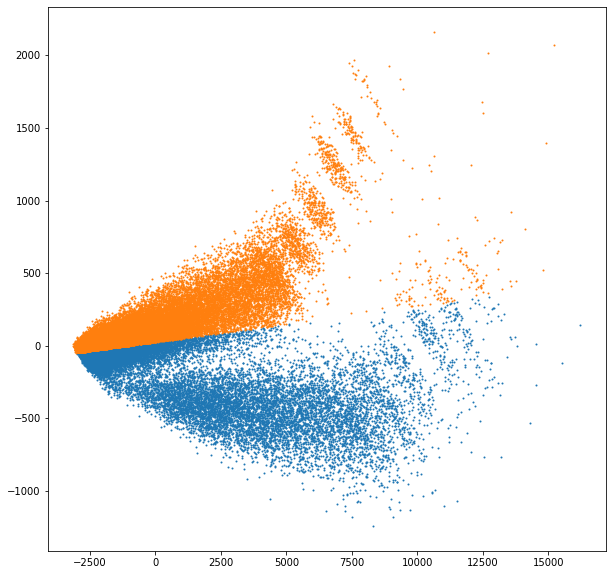

In [0]:
x_gamma = x[reduced_data[:, 3]>=0.5]
x_neut = x[reduced_data[:, 3]<0.5]
plt.figure(figsize=(10, 10))
plt.scatter(x_gamma[:, 0], x_gamma[:, 1], s=1)
plt.scatter(x_neut[:, 0], x_neut[:, 1], s=1)
plt.show()
# If we had applied k-means clustering, it would have given us different clusters
# than the ones obtained by the margin of 0.5

In [0]:
# trying k-means on the transformed data
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=5).fit_predict(reduced_data[:, 1:3])
kmeans
# k-means clustering fails to compute two clusters
# TODO: Try experimenting with the arguments, changing weights etc.

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [0]:
kmeans[kmeans==0].sum()

0

In [0]:
# Apply normalization before and after PCA
# Before
from sklearn.preprocessing import normalize
reduced_data_norm = normalize(reduced_data[:, 1:3], axis=0)

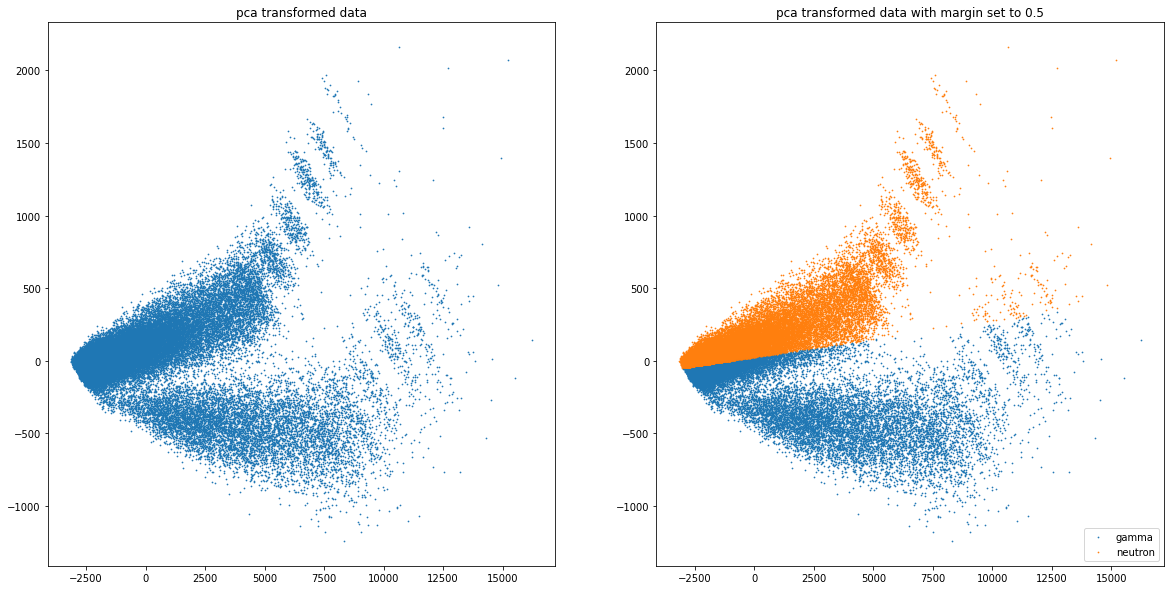

In [0]:
pca = PCA()
x_pca = pca.fit_transform(reduced_data[:, 1:3])
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#plt.figure(figsize=(30, 30))
ax[0].scatter(x_pca[:, 0], x_pca[:, 1], s=0.5)
ax[0].title.set_text('pca transformed data')
x_pca_gamma = x_pca[reduced_data[:, 3]>=0.5]
x_pca_neut = x_pca[reduced_data[:, 3]<0.5]
ax[1].scatter(x_pca_gamma[:, 0], x_pca_gamma[:, 1], s=0.5, label='gamma')
ax[1].scatter(x_pca_neut[:, 0], x_pca_neut[:, 1], s=0.5, label='neutron')
ax[1].title.set_text('pca transformed data with margin set to 0.5')
ax[1].legend(loc="lower right")
plt.show()

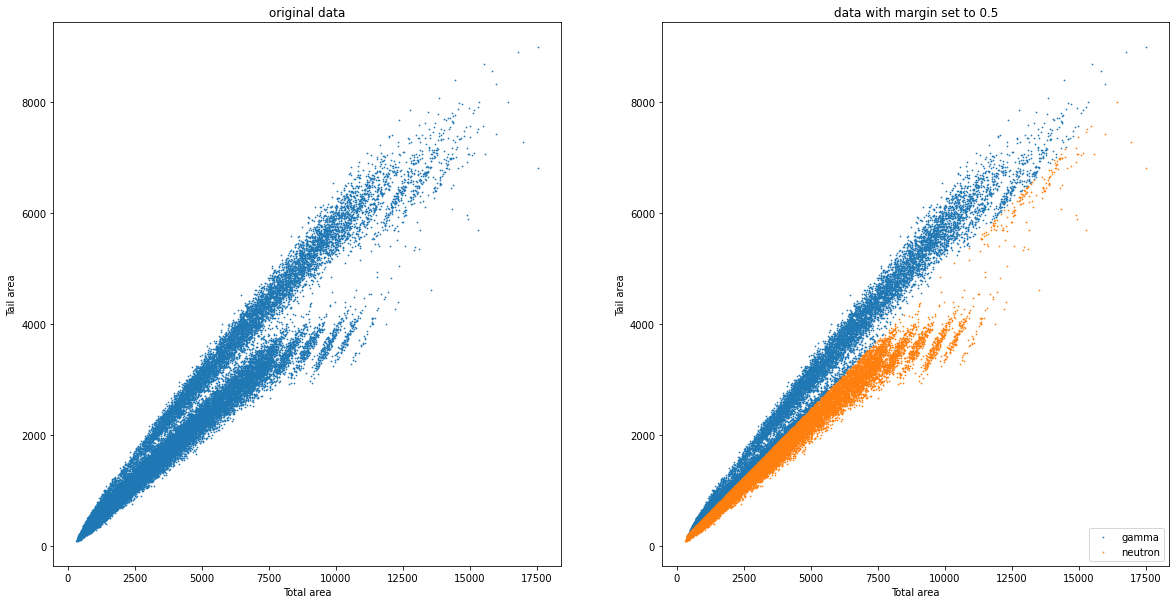

In [0]:
# plotting original data
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#plt.figure(figsize=(30, 30))
ax[0].scatter(reduced_data[:, 1], reduced_data[:, 2], s=0.5)
ax[0].title.set_text('original data')
ax[0].set_xlabel('Total area')
ax[0].set_ylabel('Tail area')
#ax[1].scatter(reduced_data_norm[:, 0], reduced_data_norm[:, 1], s=1)
#ax[1].title.set_text('with normalization')
ax[1].scatter(data_gamma[:, 1], data_gamma[:, 2], s=0.5, label='gamma')
ax[1].scatter(data_neut[:, 1], data_neut[:, 2], s=0.5, label='neutron')
ax[1].title.set_text('data with margin set to 0.5')
ax[1].set_xlabel('Total area')
ax[1].set_ylabel('Tail area')
ax[1].legend(loc="lower right")
plt.show()

In [0]:
#apply k-means 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, init=np.array([[0.003, 0.0004], [0.003, -0.0007]])).fit_predict(x_norm)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1008: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return self.fit(X, sample_weight=sample_weight).labels_


In [0]:
kmeans[kmeans==1].sum()/kmeans.size

0.23765298900378048

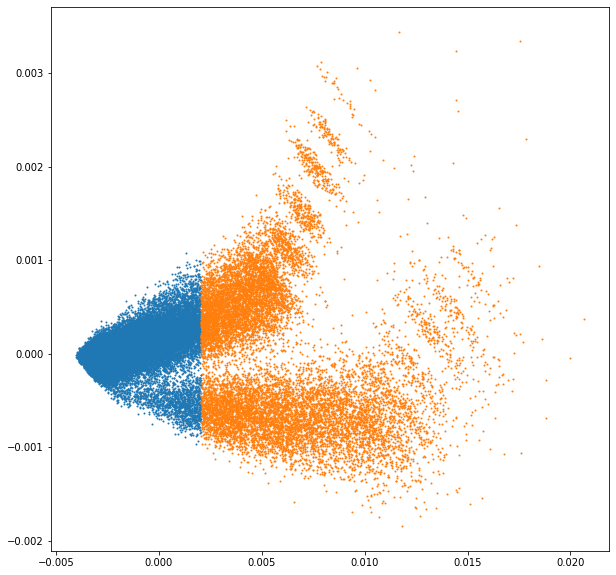

In [0]:
# plotting results of clustering
kmeans_0 = x_norm[kmeans==0]
kmeans_1 = x_norm[kmeans==1]
plt.figure(figsize=(10, 10))
plt.scatter(kmeans_0[:, 0], kmeans_0[:, 1], s=1)
plt.scatter(kmeans_1[:, 0], kmeans_1[:, 1], s=1)
plt.show()

In [0]:
# map 2-d grid on a sphere

def mapping(x, y, r):
  longitude = x/r;
  latitude = 2*np.arctan(np.exp(y/r)) - np.pi/2;
  new_pts = np.zeros([x.shape, 3])
  new_pts[0] = r * np.cos(latitude) * np.cos(latitude) # x
  new_pts[1] = r * np.cos(latitude) * np.sin(latitude) # y
  new_pts[2] = r * np.sin(latitude) # z
  return new_pts
# function to convert cartisian coordinates to spherical (not useful)
"""
def Spherical_np(xyz):
    ptsnew = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,1] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew
"""

'\ndef Spherical_np(xyz):\n    ptsnew = np.zeros(xyz.shape)\n    xy = xyz[:,0]**2 + xyz[:,1]**2\n    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)\n    ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down\n    #ptsnew[:,1] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up\n    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])\n    return ptsnew\n'

In [0]:
def mapping(x, y, r):
  longitude = x/r
  latitude = 2*np.arctan(np.exp(y/r)) - np.pi/2
  new_pts = np.zeros([x.shape[0], 3])
  new_pts[:, 0] = r * np.cos(latitude) * np.cos(latitude) # x
  new_pts[:, 1] = r * np.cos(latitude) * np.sin(latitude) # y
  new_pts[:, 2] = r * np.sin(latitude) # z
  return new_pts

In [0]:
3d_data = mapping(x_norm[:, 0], x_norm[:, 1], 10)

SyntaxError: ignored

In [0]:
r=10
longitude = x_norm[:, 1]/r
latitude = 2*np.arctan(np.exp(x_norm[:, 0]/r)) - np.pi/2
new_pts = np.zeros([x.shape[0], 3])
new_pts[:, 0] = r * np.cos(latitude) * np.cos(latitude)
new_pts[:, 1] = r * np.cos(latitude) * np.sin(latitude)
new_pts[:, 2] = r * np.sin(latitude)

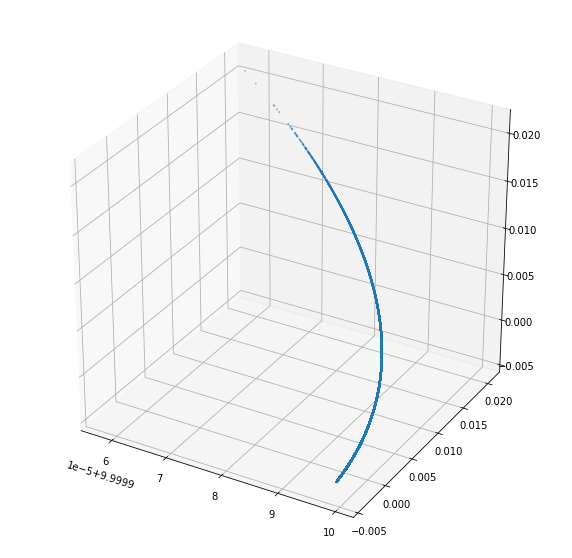

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_pts[:, 0], new_pts[:, 1], new_pts[:, 2], s=1)
plt.show()

In [0]:
# As the data is highly dense in the lower region, try using log transformation
reduced_data_log = np.log(reduced_data)
log_gamma = np.log(reduced_data[reduced_data[:, 3]>=0.5])
log_neut = np.log(reduced_data[reduced_data[:, 3]<0.5])

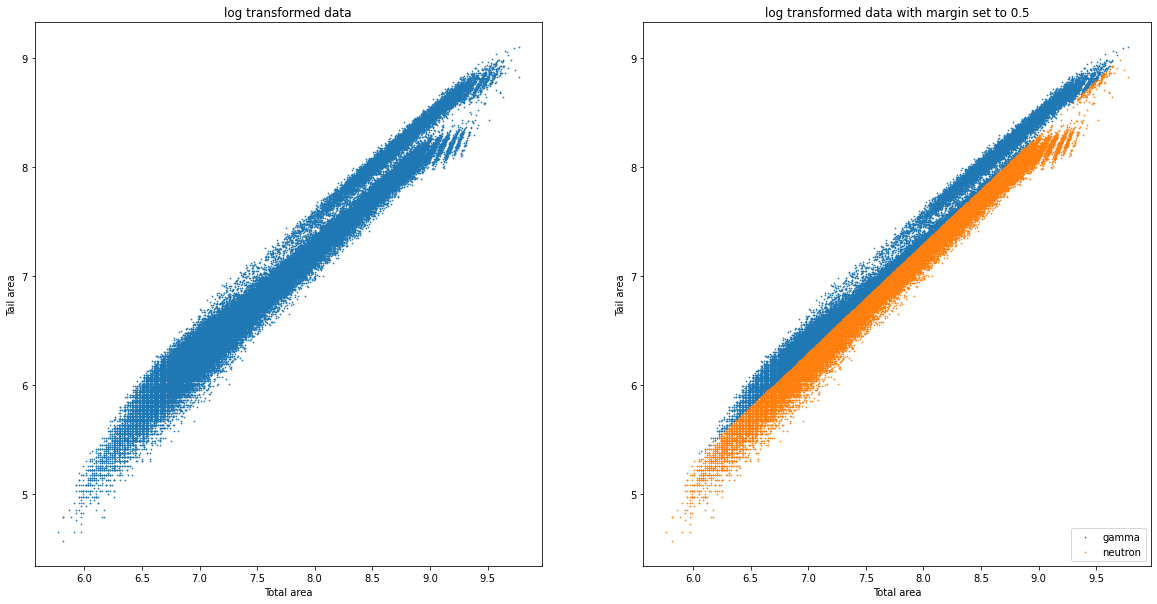

In [0]:
# plotting log transformed data
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#plt.figure(figsize=(30, 30))
reduced_data_log = np.log(reduced_data[:, 1:3])
ax[0].scatter(reduced_data_log[:, 0], reduced_data_log[:, 1], s=0.5)
ax[0].title.set_text('log transformed data')
ax[0].set_xlabel('Total area')
ax[0].set_ylabel('Tail area')
#ax[1].scatter(reduced_data_norm[:, 0], reduced_data_norm[:, 1], s=1)
#ax[1].title.set_text('with normalization')
data_gamma_log = reduced_data_log[reduced_data[:, 3]>=0.5]
data_neut_log = reduced_data_log[reduced_data[:, 3]<0.5]
ax[1].scatter(data_gamma_log[:, 0], data_gamma_log[:, 1], s=0.5, label='gamma')
ax[1].scatter(data_neut_log[:, 0], data_neut_log[:, 1], s=0.5, label='neutron')
ax[1].title.set_text('log transformed data with margin set to 0.5')
ax[1].set_xlabel('Total area')
ax[1].set_ylabel('Tail area')
ax[1].legend(loc="lower right")
plt.show()

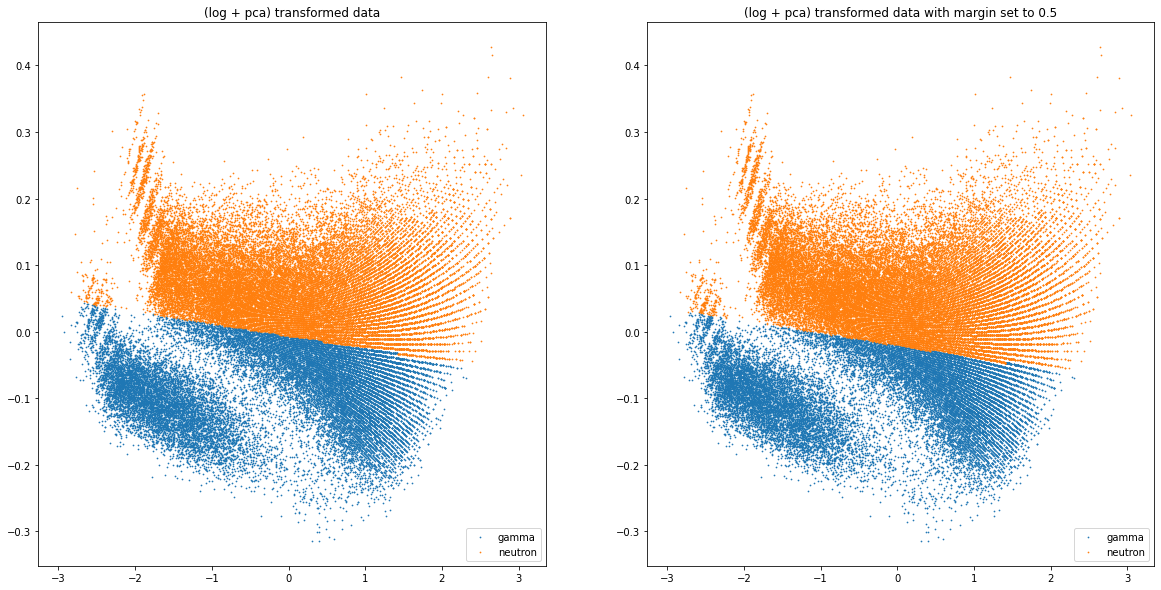

In [0]:
# do pca on the log transformed data
pca = PCA()
log_pca_data = pca.fit_transform(reduced_data_log)
log_pca_gamma_0 = log_pca_data[reduced_data[:, 3]>=0.5]
log_pca_neut_0 = log_pca_data[reduced_data[:, 3]<0.5]
log_pca_gamma_1 = log_pca_data[reduced_data[:, 3]>0.5]
log_pca_neut_1 = log_pca_data[reduced_data[:, 3]<=0.5]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#ax[0].scatter(log_pca_data[:, 0], log_pca_data[:, 1], s=0.5)
ax[0].scatter(log_pca_gamma_0[:, 0], log_pca_gamma_0[:, 1], s=0.5, label='gamma')
ax[0].scatter(log_pca_neut_0[:, 0], log_pca_neut_0[:, 1], s=0.5, label='neutron')
ax[0].legend(loc="lower right")
ax[0].title.set_text('(log + pca) transformed data')
ax[1].scatter(log_pca_gamma_1[:, 0], log_pca_gamma_1[:, 1], s=0.5, label='gamma')
ax[1].scatter(log_pca_neut_1[:, 0], log_pca_neut_1[:, 1], s=0.5, label='neutron')
ax[1].title.set_text('(log + pca) transformed data with margin set to 0.5')
ax[1].legend(loc="lower right")
plt.show()

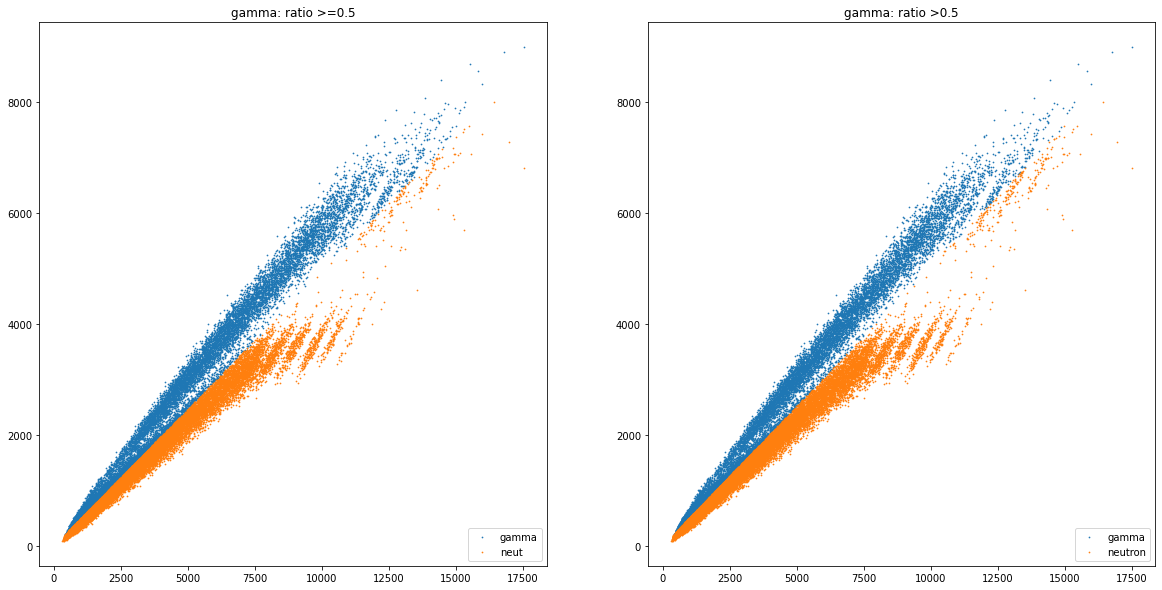

In [0]:
# slightly changing the boundary condition
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
gamma_0 = reduced_data[reduced_data[:, 3]>=0.5]
neut_0 = reduced_data[reduced_data[:, 3]<0.5]
ax[0].scatter(gamma_0[:, 1], gamma_0[:, 2], s=0.5, label='gamma')
ax[0].scatter(neut_0[:, 1], neut_0[:, 2], s=0.5, label='neut')
ax[0].title.set_text('gamma: ratio >=0.5')
ax[0].legend(loc="lower right")

gamma_1 = reduced_data[reduced_data[:, 3]>0.5]
neut_1 = reduced_data[reduced_data[:, 3]<=0.5]
ax[1].scatter(gamma_1[:, 1], gamma_1[:, 2], s=0.5, label='gamma')
ax[1].scatter(neut_1[:, 1], neut_1[:, 2], s=0.5, label='neutron')
ax[1].title.set_text('gamma: ratio >0.5')
ax[1].legend(loc="lower right")
plt.show()

In [0]:
print(gamma_0[:, 0].size/reduced_data[:, 0].size, gamma_1[:, 0].size/reduced_data[:, 0].size)
# ~5% decrease in datapoints labelled as gamma on chaging the equality condition

0.4433875951595919 0.39337810077853924


In [0]:
# apply k-means
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(log_pca_data)

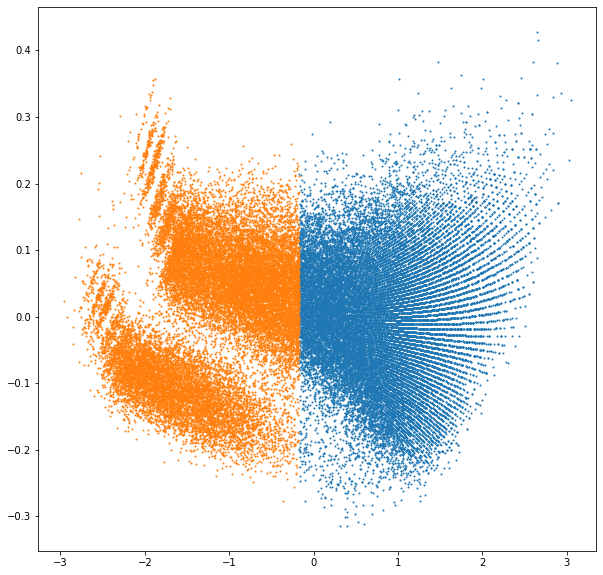

In [0]:
kmeans_0 = log_pca_data[kmeans==0]
kmeans_1 = log_pca_data[kmeans==1]
plt.figure(figsize=(10, 10))
plt.scatter(kmeans_0[:, 0], kmeans_0[:, 1], s=1)
plt.scatter(kmeans_1[:, 0], kmeans_1[:, 1], s=1)
plt.show()
## there is somthing wrong with k-means, even though we can visually figure out two clusters, k-means fails to do so.
## impprove clustering techniques

In [0]:
# try density based clustering
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps=0.01).fit_predict(log_pca_data)

In [0]:
plt.figure(figsize=(10, 10))
plt.scatter(log_pca_data[dbsc==0])

In [0]:
np.unique(dbsc)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [0]:
dbsc.size

57929

In [0]:
# try aggloremative clustering
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering().fit_predict(log_pca_data)

NameError: ignored

In [0]:
agc[agc==0].size